# Tests for the model following Luo and Rudy
Tim Tyree<br>
start - 1.7.2021,
end - 1.15.2021

In [1]:
from lib.my_initialization import *
from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.measure.utils_measure_tips_cpu import *
from lib.utils.stack_txt_LR import *
from lib.viewer import *
import trackpy

from lib.my_initialization import *
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.viewer import *
import trackpy
from lib.controller import *
from lib.model.LR_model import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


## TODO list

__To Methods(initialization of LR model): comparing the fast/slow fields to those of the LR model__
for the textures loaded from the minimal model (V,f,s).  
- _the fast field:_ F-channel is high in the repolarized tissue and low in the polarized tissue
- _the slow field:_ S-channel is never lower than ~0.67 anywhere

looking at the 0D action potentials from the LR model, 
- $m$ looks like 1-F
- $h$ looks like F
- $j$ looks like F
- $d$ looks like 1-F
- $f$ looks like S
- $w$ looks like 1-S (AKA x_var, or the x-field)

In [2]:
#TODO: compute Iion_values
#TODO: plot IV curves of the LR model.
#TODO: plot Iion versus various arguments
#TODO: use IV curves of the LR model to make a lookup table
#TODO: for lookup table, make an N-linear interpolation function.  Can N=1? or N=2 or 8?
#TODO: measure the speedup between using simple implementation versus using a lookup table
chnlno=8#Iion_values.shape[-1]
argument_grid=None

# TODO: Visualize intercellular calcium dynamics
# TODO: Visualize I vs. V curves and verify they agree with Qu2000 or Luo1990
#Hint: calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
# 		dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)

#TODO: implement a linear wave for making plots in methods
#TODO: determine which gates are on/off for a linear action potential
#TODO: plot I versus V for various gates on/off


# - DONE: plot Iion versus various arguments
# - DONE: estimate which ranges should be precomputed
# - TODO: define lookup_Iion function that uses linear interpolation of nearest Iion_values.  Note that 
# - TODO: generate lookup table for Luo-Rudy Model
# - TODO: check that result of comp_rate_of_change_at_pixel_LR yields timesteps correctly/reasonably.  if not, maybe x and y are flipped.

# TODO(later): plot the Multivariable currents somehow.  Consider 2-3 values of each gating variable chosen at max/half/min voltage
#Multivariable currents
# #Fast sodium current
# INa = GNa*m**3*h*j*(V-ENa)
# Isi=Gsi*d*f*(V-Esi)
# #Slow inward current
# Esi=7.7-13.0287*np.log(Ca_i)#mV
# Isi=Gsi*d*f*(V-Esi)

# - TODO(later): plot range for Ca_i
# - TODO(later): plot I/V curve for gate state in each phase of the apparent action potential

#TODO(later): compute the laplacian of the four pixels called by the intersection algorithm
#TODO(later): interpolate laplacian of voltage at spiral tip
#TODO(later): cythonize ^this
#TODO(later): compute time series of laplacian(voltage(location_of_spiral_tip))
#TODO(later): compare ^this with nine point stencil
#TODO(generalization of paper topic): write ^this up
# On the Brownian particle properties of spiral tips resulting from spiral defect chaos applied to electrophysiological models


# Simple local tests for given pixel

In [6]:
#test scaling from mV to dimensionless voltage for plotting
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
txt_plt = get_voltage_field_scaled_and_shifted(txt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
assert np.isclose(np.max(txt_plt),1.,atol=1e-1)
assert np.isclose(np.min(txt_plt),0.,atol=1e-10)

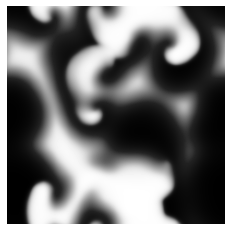

In [7]:
plt.imshow(txt_plt, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# input_file_name=search_for_file()
# print ( input_file_name )
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
inVmhjdfxc = load_buffer_LR(input_file_name)
txt=inVmhjdfxc
zero_txt = np.zeros_like(txt)
width,height,chnlno = txt.shape
print (f"buffer dimensions are width, height, chnlno = { width,height,chnlno }.") 
comp_ionic_currents = get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit')

comp_rate_of_change_at_pixel_LR=get_comp_rate_of_change_at_pixel_LR(ds = 0.015, width =200, height=200, 
Cm=1., diffCoef=0.001, Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,
method='njit')

buffer dimensions are width, height, chnlno = (200, 200, 8).


In [9]:
from lib.model.LR_model import pbc

In [10]:
#local tests
x=5;y=7
C = pbc(inVmhjdfxc, x, y)
assert C.shape[0]==8
V = C[0] #mV transmembrane voltage 
#gating variables
m = C[1] #activation gate parameter (Na)
h = C[2] #fast inactivation gate parameter (INa)
j = C[3] #slow inactivation gate parameter (INa)
d = C[4] #activation gate parameter (Isi)
f = C[5] #inactivation gate parameter (Isi)
x_var = C[6] #activation gate parameter (IK)
Ca_i = C[7] # calcium concentration inside the cell 
#test comp_ionic_currents
Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)
assert Iion
assert dCa_i_dt

cddx=1.;cddy=1.#not actual values
#test laplacian
dVltdt=laplacian(inVmhjdfxc, x, y, cddx, cddy, V)
assert dVltdt 

#test comp_rate_of_change_at_pixel_LR
retval = comp_rate_of_change_at_pixel_LR(txt, x, y)
assert retval.shape[0]==8

In [11]:
#percent of nan values in Vfield
Vfield=txt[...,0]
print(f"percent of nan values in Vfield is {100*Vfield[np.isnan(Vfield)].size/Vfield.size}%.")

percent of nan values in Vfield is 0.0%.


In [12]:
##################################################
# Test comp_ionic_currents
##################################################
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
inVmhjdfxc = load_buffer_LR(input_file_name)
txt = inVmhjdfxc
comp_ionic_currents = get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit')

In [13]:

x=1;y=2
C = pbc(inVmhjdfxc, x, y)
V = C[0] #mV transmembrane voltage 
#gating variables
m = C[1] #activation gate parameter (Na)
h = C[2] #fast inactivation gate parameter (INa)
j = C[3] #slow inactivation gate parameter (INa)
d = C[4] #activation gate parameter (Isi)
f = C[5] #inactivation gate parameter (Isi)
x_var = C[6] #activation gate parameter (IK)
Ca_i = C[7] # calcium concentration inside the cell 
# Ca_i = pbc(inCa_i, x, y)[0]
Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)

In [14]:
Iion

-69.86215678817254

In [15]:
dCa_i_dt

-7.608433991447333e-05

In [16]:
m, h, j, d, f, x_var

(0.3696349871813035,
 0.9760519948036207,
 0.6303650128186965,
 0.34229077821876275,
 0.9260237534031684,
 0.07397624659683155)

# Plot comp_gating_constants versus V

In [17]:
#DONE: Visualize I vs. V curves and verify they agree with Qu2000 or Luo1990#DONE: plot comp_gating_constants versus V
#DONE: plot get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit',**kwargs)

V = 10.
comp_gating_constants=get_comp_gating_constants()
retval=comp_gating_constants(V)
retval

array([5.44235137e-02, 2.02119333e-02, 3.38332717e+00, 1.81851447e+01,
       3.39076577e+02, 4.04991595e+02, 9.98245863e-01, 0.00000000e+00,
       0.00000000e+00, 9.67989732e-01, 1.00120788e-02, 9.33116780e-01])

In [18]:
#test comp_gating_constants
retval=comp_gating_constants(V)
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x, m_infty, h_infty, j_infty, d_infty, f_infty, x_infty=retval
assert retval.shape[0]==12

In [19]:
h = 0.5
dhdt = comp_transient_gating_variable(h, tau_h, h_infty)
tau_h

0.020211933336177223

In [20]:
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x 
# m_infty, h_infty, j_infty, d_infty, f_infty, x_infty

(0.054423513669504,
 0.020211933336177223,
 3.3833271661250874,
 18.18514473601371,
 339.076576667244,
 404.99159458541783)

In [21]:
#compute the gating variables versus voltage
Vmin=-85.
Vmax=35.#35.
num_values=100
V_values = np.linspace(Vmin,Vmax,num_values)
x_values = V_values
retval_lst = []
for V in V_values:
    retval=comp_gating_constants(V)
    retval_lst.append(retval)
retval_values=np.array(retval_lst)
#rate constants
tau_m_values=retval_values[:,0]
tau_h_values=retval_values[:,1]
tau_j_values=retval_values[:,2]
tau_d_values=retval_values[:,3]
tau_f_values=retval_values[:,4]
tau_x_values=retval_values[:,5]
#equilibrium constants
m_infty_values=retval_values[:,6]
h_infty_values=retval_values[:,7]
j_infty_values=retval_values[:,8]
d_infty_values=retval_values[:,9]
f_infty_values=retval_values[:,10]
x_infty_values=retval_values[:,11]

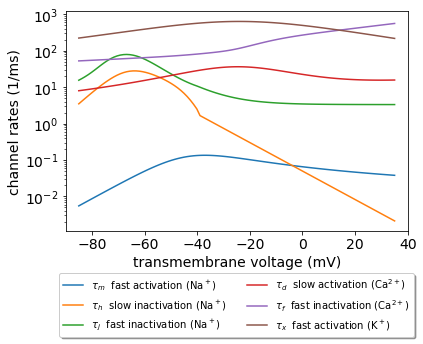

In [22]:
#plot channel rates versus V
fontsize=14
save=True
plt.subplots(figsize=(6,5))
plt.plot(x_values,tau_m_values, label=r'$\tau_m$  fast activation (Na$^+$)')
plt.plot(x_values,tau_h_values, label=r'$\tau_h$  slow inactivation (Na$^+$)')
plt.plot(x_values,tau_j_values, label=r'$\tau_j$  fast inactivation (Na$^+$)')
plt.plot(x_values,tau_d_values, label=r'$\tau_d$  slow activation (Ca$^{2+}$)')
plt.plot(x_values,tau_f_values, label=r'$\tau_f$  fast inactivation (Ca$^{2+}$)')
plt.plot(x_values,tau_x_values, label=r'$\tau_x$  fast activation (K$^+$)')
plt.legend(ncol=2, fontsize=fontsize-4,loc='upper center',bbox_to_anchor=(0.5, -0.17),fancybox=True, shadow=True)
plt.yscale('log')
plt.xlim([-90,40])
plt.tick_params(labelsize=fontsize)
plt.xlabel('transmembrane voltage (mV)', fontsize=fontsize)
plt.ylabel('channel rates (1/ms)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_rates.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

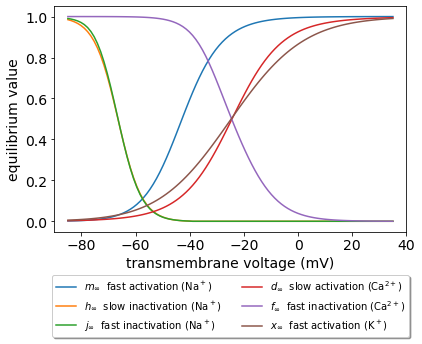

In [23]:
#plot equilibrium values versus V
fontsize=14
save=True
plt.subplots(figsize=(6,5))
plt.plot(x_values,m_infty_values, label=r'$m_\infty$  fast activation (Na$^+$)')
plt.plot(x_values,h_infty_values, label=r'$h_\infty$  slow inactivation (Na$^+$)')
plt.plot(x_values,j_infty_values, label=r'$j_\infty$  fast inactivation (Na$^+$)')
plt.plot(x_values,d_infty_values, label=r'$d_\infty$  slow activation (Ca$^{2+}$)')
plt.plot(x_values,f_infty_values, label=r'$f_\infty$  fast inactivation (Ca$^{2+}$)')
plt.plot(x_values,x_infty_values, label=r'$x_\infty$  fast activation (K$^+$)')
plt.legend(ncol=2, fontsize=fontsize-4,loc='upper center',bbox_to_anchor=(0.5, -0.17),fancybox=True, shadow=True)
# plt.yscale('log')
plt.xlim([-90,40])
plt.tick_params(labelsize=fontsize)
plt.xlabel('transmembrane voltage (mV)', fontsize=fontsize)
plt.ylabel('equilibrium value', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_equilibrium_values.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

# Plot simple variable current sources

_to Methods on the introduction of \section_{ __Electrophysiological model following Luo and Rudy__ }

The fast potassium current, $I_{K_f}$ has previously been referred to as the time-dependent potassium current and the slow potassium current, $I_{K_s}$has previously been referred to as the plateau potassium current CITE Luo1990.pdf.

The change has been made to name the dynamical variable $w\in[0,1]$ instead of $x$ to avoid confusion with the spatial coordinate, $x$.

In [24]:
#maximum conductances
GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
GK  = 0.423   #mS/cm^2 #from Qu2000.pdf

#reversal potentials
EK1 = -87.94
EKp = EK1
Eb = -59.87 #mV
EK=-77.0

#compute the gating variables versus voltage
Vmin=-85.
Vmax=35.
num_values=50
V_values = np.linspace(Vmin,Vmax,num_values)

In [25]:
#compute Single variable currents versus voltage
IKp_lst=[]; Ib_lst=[]; IK1_lst=[]
for V in V_values:
    #Slow potassium current
    Kp=1.0/(1.0+np.exp((7.488-V)/5.98))
    IKp=0.0183*Kp*(V-EKp)

    #Fast potassium parameters
    aK1=1.02/(1.0+np.exp(0.2385*(V-EK1-59.215)))
    bK1=(0.49124*np.exp(0.08032*(V-EK1-5.476)))+np.exp(0.06175*(V-EK1-594.31))/(1.0+np.exp(-0.5143*(V-EK1+4.753)))
    K1infty = aK1/(aK1 + bK1)
    #fast potassium current (A)
    IK1=GK1*K1infty*(V-EK1)

    #Background Current
    Ib=0.03921*(V+59.87)
    
    IK1_lst.append(IK1)
    IKp_lst.append(IKp)
    Ib_lst.append(Ib)
IKf_values = np.array(IK1_lst)
IKs_values = np.array(IKp_lst)
Ib_values = np.array(Ib_lst)

In [26]:
#instead of the 3D plots, use x=0,0.5,1 for a standard plt.plot
IKa_lst = [];IKb_lst = [];IKc_lst = [];
xa=0.;xb=0.5;xc=1.0;
for V in V_values:
    #fast potassium current (B)
    if V>-100.0:#mV
        x1=2.837*(np.exp(0.04*(V+77.0))-1.0)/(V+77.0)*np.exp(0.04*(V+35.0))
    else:
        x1=1.0
    IK=GK*xa*x1*(V-EK)
    IKa_lst.append(IK)
    IK=GK*xb*x1*(V-EK)
    IKb_lst.append(IK)
    IK=GK*xc*x1*(V-EK)
    IKc_lst.append(IK)
IKfa_values = np.array(IKa_lst)
IKfb_values = np.array(IKb_lst)
IKfc_values = np.array(IKc_lst)

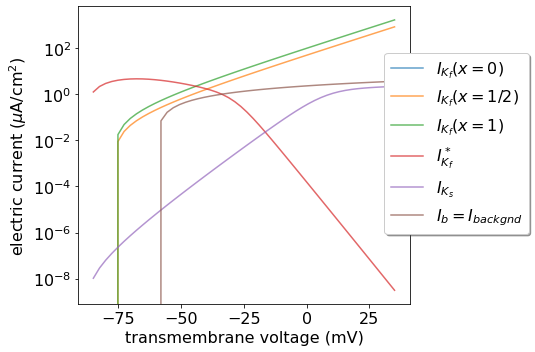

In [27]:
#plot simple currents versus V
fontsize=16
save=True
plt.subplots(figsize=(7.5,5))
plt.plot(V_values,IKfa_values,alpha=0.7,label=r'$I_{K_f}(x=0)$')
plt.plot(V_values,IKfb_values,alpha=0.7,label=r'$I_{K_f}(x=1/2)$')
plt.plot(V_values,IKfc_values,alpha=0.7,label=r'$I_{K_f}(x=1)$')
plt.plot(V_values,IKf_values,alpha=0.7,label=r'${I}^*_{K_f}}$')
plt.plot(V_values,IKs_values,alpha=0.7,label=r'$I_{K_s}$')
plt.plot(V_values,Ib_values,alpha=0.7,label=r'$I_{b}=I_{backgnd}$')
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r'transmembrane voltage (mV)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('electric current ($\mu$A/cm$^2$)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_simple_currents.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

## TODO(later): Plot I/V curves y=0,0.5,1. for y in {m,h,j,d,f}

# Action potentials from the LR model in 0D

## Simulation of one action potential in 0D
using $\frac{dV}{dt}=-I_{ion}/C_m$ to advance $V(t=0)=V_{activ.}+\delta V$,


In [ ]:
#initialize integration
# Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells

# initialize V et alli
#TODO: initialize V, m, h, j, d, f, x_var, Ca_i at the Q wave of the PQRST complex
# print ( V, m, h, j, d, f, x_var, Ca_i )

In [28]:
tf = 1000#5000#1000
dt=0.001 #ms
# V=-50.#-35.#-3.7#0.#-40. #mV
Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
V, m, h, j, d, f, x_var, Ca_i=(-30.0,
 1.,
 1.,
 1.,
 0.,
 0.,
 0.,
 1.4e-7)##0.0002)

# -84.660321188012958
# 1.4545256072491180E-007
# 5.5810241673725797E-003
# 1.6354133541151676E-003
# 0.98371668922815847
# 0.98977009269126759
# 2.9491168042779553E-003
# 0.99998163447373467

comp_gating_constants=get_comp_gating_constants()

K_i=145.0;K_o=5.4;ENa=54.4;EK=-77.0
num_time_steps=int(tf/dt)
t_values=np.array([j*dt for j in range(num_time_steps)])
#forward euler integrate V to time t, saving values
V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
IK_lst=[];INa_lst=[];ICa_lst=[];
for t in t_values:
#     Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)
    #update the gating vars
    retval=comp_gating_constants(V)
    tau_m, tau_h, tau_j, tau_d, tau_f, tau_x, m_infty, h_infty, j_infty, d_infty, f_infty, x_infty=retval
    dmdt = comp_transient_gating_variable(m, tau_m, m_infty)
    dhdt = comp_transient_gating_variable(h, tau_h, h_infty)
    djdt = comp_transient_gating_variable(j, tau_j, j_infty)
    dddt = comp_transient_gating_variable(d, tau_d, d_infty)
    dfdt = comp_transient_gating_variable(f, tau_f, f_infty)
    dxdt = comp_transient_gating_variable(x_var, tau_x, x_infty)
    
    #for plotting, compute the insides of comp_ionic_currents
    #maximum conductances
    GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
    GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
    Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
    GK  = 0.423   #mS/cm^2 #from Qu2000.pdf
    #Gsi = 0.038  #mS/cm^2  chaotic meander phase from Qu2000.pdf
    #Gsi = 0.     #mS/cm^2 quasiperiodic phase from Qu2000.pdf
    #reversal potentials
    EK1 = -87.94
    EKp = EK1
    Eb = -59.87 #mV
    #Fast sodium current
    INa = GNa*m**3*h*j*(V-ENa)
    #Slow inward current
    Esi=7.7-13.0287*np.log(Ca_i)#mV
    Isi=Gsi*d*f*(V-Esi)
    #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
    dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)
    #Time-dependent potassium current
    if V>-100:#mV
        x1=2.837*(np.exp(0.04*(V+77.0))-1.0)/(V+77.0)*np.exp(0.04*(V+35.0))
    else:
        x1=1.0
    IK=GK*x_var*x1*(V-EK)
    #Time-independent potassium parameters
    aK1=1.02/(1.0+np.exp(0.2385*(V-EK1-59.215)))
    bK1=(0.49124*np.exp(0.08032*(V-EK1-5.476)))+np.exp(0.06175*(V-EK1-594.31))/(1.0+np.exp(-0.5143*(V-EK1+4.753)))
    K1infty = aK1/(aK1 + bK1)
    #fast potassium current
    IK1=GK1*K1infty*(V-EK1)
    #Plateau potassium current
    Kp=1.0/(1.0+np.exp((7.488-V)/5.98))
    IKp=0.0183*Kp*(V-EKp)
    #Background Current
    Ib=0.03921*(V+59.87)
    #Total time-independent potassium current
    IK1T=IK1+IKp+Ib
    IK_lst.append(IK1T+IK);ICa_lst.append(Isi);INa_lst.append(INa)
    
    Iion = IK1T+INa+Isi+IK
    dVdt=-Iion/Cm
    V += dt*dVdt
    
    
    m+=dt*dmdt
    h+=dt*dhdt
    j+=dt*djdt
    d+=dt*dddt
    f+=dt*dfdt
    x_var+=dt*dxdt
    Ca_i+=dt*dCa_i_dt
    V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
V_values=np.array(V_lst)
#gating values
m_values=np.array(m_lst)
h_values=np.array(h_lst)
j_values=np.array(j_lst)
d_values=np.array(d_lst)
f_values=np.array(f_lst)
x_var_values=np.array(x_var_lst)
Ca_i_values=np.array(Ca_i_lst)
#current values
IK_values=np.array(IK_lst)
ICa_values=np.array(ICa_lst)
INa_values=np.array(INa_lst)

beep(1)

0

### plot action potential 

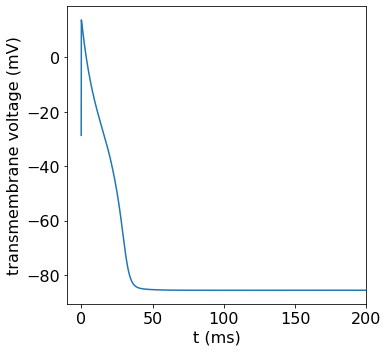

In [29]:
#voltage
fontsize=16
save=True

plt.subplots(figsize=(5.5,5))
plt.plot(t_values,V_values)
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane voltage (mV)', fontsize=fontsize)
plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_voltage.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

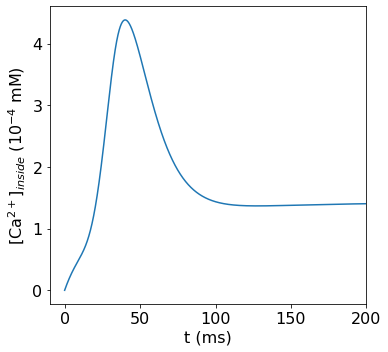

In [30]:
#calcium
fontsize=16
save=True
plt.subplots(figsize=(5.5,5))
plt.plot(t_values,Ca_i_values*10**+4)
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.xlim([-10,200])
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel(r'[Ca$^{2+}]_{inside}$ ($10^{-4}$ mM)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    savefig_fn='LR_model_calcium.png'
    plt.savefig(savefig_fn,dpi=300)

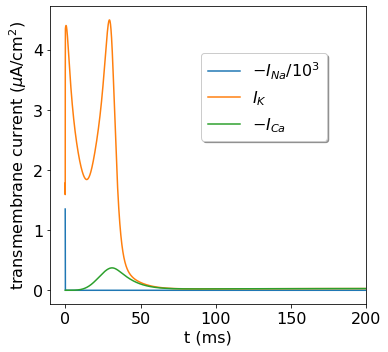

In [31]:
#plot current versus t
fontsize=16
save=True
plt.subplots(figsize=(5.5,5))
plt.plot(t_values,-INa_values/10**3,label=r'$-I_{Na}/10^3$')
plt.plot(t_values,IK_values,label=r'$I_{K}$')
plt.plot(t_values,-ICa_values,label=r'$-I_{Ca}$')
plt.xlim([-10,200])
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane current ($\mu$A/cm$^2$)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_AP_current.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

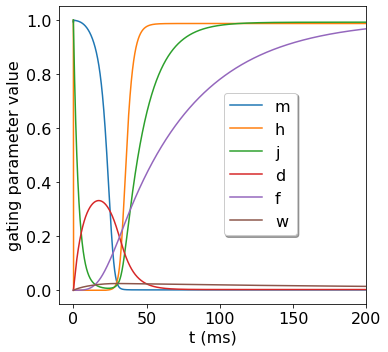

In [32]:
#plot gating variables versus t
fontsize=16
save=True
plt.subplots(figsize=(5.5,5))
plt.plot(t_values,m_values,label='m')
plt.plot(t_values,h_values,label='h')
plt.plot(t_values,j_values,label='j')
plt.plot(t_values,d_values,label='d')
plt.plot(t_values,f_values,label='f')
plt.plot(t_values,x_var_values,label='w')
plt.legend(ncol=1, fontsize=fontsize,loc='right', bbox_to_anchor=(.8,.47), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('gating parameter value', fontsize=fontsize)
plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_AP_gating_params.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [33]:
# plt.ylabel('channel rates (1/ms)', fontsize=fontsize)

In [34]:
beep(2)

0

In [35]:
df=pd.DataFrame({
    't':t_values,
    'V':V_values,
    'Ca_i':Ca_i_values,
    'INa':INa_values,
    'IK' :IK_values,
    'ICa':ICa_values,
    'm':m_values,
    'h':h_values,
    'j':j_values,
    'd':d_values,
    'f':f_values,
    'x_var':x_var_values,
})

In [36]:
# os.chdir(nb_dir)
os.chdir(os.path.join(nb_dir,'Figures/methods'))
df.to_csv('LR_action_potential.csv')

## Simulation of three externally stimulated 0D action potentials from the LR model 
using the lookup table generated by `gener_table.py`

In [28]:
@njit
def I_stim(I_magnitude=1.77,t_duration=100.):
    return I_magnitude

In [29]:
def get_mycomp_ionic_flux(GNa=16.,GK1=0.6047,Gsi=0.052,EK1=-87.94,Eb=-59.87,ENa=54.4):#,GK=0.423
    # #maximum conductances
    # GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
    # GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
    # Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
    # GK  = 0.423   #mS/cm^2 #from Qu2000.pdf
    # #reversal potentials
    # EK1 = -87.94 #mV
    # EKp = EK1    #mV
    # Eb  = -59.87 #mV
    # ENa = 54.4   #mV
    
    
#     @njit
#     def mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i):
#         """returns updated  gating variables"""
#         m = inCgate[0] #activation gate parameter (Na)
#         h = inCgate[1] #fast inactivation gate parameter (INa)
#         j = inCgate[2] #slow inactivation gate parameter (INa)
#         d = inCgate[3] #activation gate parameter (Isi)
#         f = inCgate[4] #inactivation gate parameter (Isi)
#         x_var = inCgate[5] #activation gate parameter (IK)
#         #Fast sodium current
#         INa = GNa*m**3*h*j*(V-ENa)
#         #Slow inward current
#         Esi=7.7-13.0287*np.log(Ca_i)#mV
#         Esi=-82.3-13.0287*np.log(Ca_i)#mV  #from lr_d0.f (WJ)
#         Isi=Gsi*d*f*(V-Esi)
#         #time dependent potassium current 
#         IK=x_var*x1#GK*x_var*x1
#         #total electric current
#         Iion=INa+IK1T+Isi+IK
#         #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
#         # dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i) #mM #from Luo1990.pdf
#         dCa_i_dt=-10**-7*Isi+0.07*(10**-7-Ca_i)   #M  #from lr_d0.f (WJ)
#         return INa,IK1T,Isi,IK, dCa_i_dt
#     return mycomp_ionic_flux

    @njit
    def comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i):
        """returns updated  gating variables"""
        m = inCgate[0] #activation gate parameter (Na)
        h = inCgate[1] #fast inactivation gate parameter (INa)
        j = inCgate[2] #slow inactivation gate parameter (INa)
        d = inCgate[3] #activation gate parameter (Isi)
        f = inCgate[4] #inactivation gate parameter (Isi)
        x_var = inCgate[5] #activation gate parameter (IK)
        #Fast sodium current
        INa = GNa*m**3*h*j*(V-ENa)
        #Slow inward current
        # Esi=7.7-13.0287*np.log(Ca_i)#mV  #from Luo1990.pdf
        Esi=-82.3-13.0287*np.log(Ca_i)#mV  #from lr_d0.f (WJ)
        Isi=Gsi*d*f*(V-Esi)
        #time dependent potassium current 
        IK=x_var*x1#GK*x_var*x1#
        #total electric current
        Iion=INa+IK1T+Isi+IK
        #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
        # dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i) #mM #from Luo1990.pdf
        dCa_i_dt=-10**-7 * Isi + 0.07*(10**-7 - Ca_i)   #M  #from lr_d0.f (WJ)
        return INa,IK1T,Isi,IK, dCa_i_dt
    return comp_ionic_flux

In [30]:
# dt=0.1 #ms
# #determine the resting state of local model
# df = pd.read_csv(os.path.join(nb_dir,'LR_action_potential.csv'))
# mean_of_tail=df.tail(10).mean()
# mean_of_tail_values=mean_of_tail.values
# #initialize system using resting state of previous model
# V   = -85.#58#043334867565#mean_of_tail['V']
# Ca_i= .00014#230357439265403#mean_of_tail['Ca_i']
# m   = 0.#00140291250464877#mean_of_tail['m']
# h   = 1.#0.9867348070020459#mean_of_tail['h']
# j   = 1.#0.9915824395060285#mean_of_tail['j']
# d   = 0.#002728930511184784#mean_of_tail['d']
# f   = 1.#0.9999835469722693#mean_of_tail['f']
# x_var = 0.#0060722026581493185#mean_of_tail['x_var']

In [51]:
# #initialize system using resting state from WJ
dt=0.1 #ms
V   = -84.660321188012958
Ca_i= 1.4545256072491180E-007

x_var   =  5.5810241673725797E-003
m   =  1.6354133541151676E-003
h   =  0.98371668922815847
j   =  0.98977009269126759
d   =  2.9491168042779553E-003
f   =  0.99998163447373467

inCgate=np.array([m,h,j,d,f,x_var])
outCgate=inCgate.copy()
#initialize methods
Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
#precompute lookup table
arr39=get_arr39(dt,nb_dir)
v_values=arr39[:,0]
lookup_params=get_lookup_params(v_values,dv=0.1)
mycomp_ionic_flux=get_mycomp_ionic_flux()
#[V,Ca_i,m,h,j,d,f,x_var]

In [53]:
tf = 500#ONE_SPIKE
tf =2000#up to 2 seconds
count=0.
dur=5.
mag=-10.#
#       xstim=10.
#       tstim=5.
#       nstim=nint(tstim/dt)
# forward integrate to tf
num_time_steps=int(tf/dt)
t_values=np.array([j*dt for j in range(num_time_steps)])
#forward euler integrate V to time t, saving all dynamic values
V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
IK_lst=[];INa_lst=[];ICa_lst=[];Istim_lst=[];Iion_lst=[]
for t in t_values:
    #compute currents
    arr_interp=lookup_params(V,arr39)
    x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
    INa,IK1T,Isi,IK,dCa_i_dt=mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
    Iion=INa+IK1T+Isi+IK
    #compute external stimulus
    if ((t>0.) & (t<0.+dur))|((t>500.) & (t<500.+dur))|((t>1000.) & (t<1000.+dur)):
    #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
        Istim=mag
    else:
        Istim=0.
    
    #record time and variables
    m,h,j,d,f,x_var=inCgate.T
    V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
    Istim_lst.append(Istim);IK_lst.append(IK+IK1T);ICa_lst.append(Isi);INa_lst.append(INa);Iion_lst.append(Iion)
    
    #integrate variables
    comp_exact_next_gating_var(inCgate, outCgate, arr_interp)
    inCgate=outCgate.copy()
    dVdt=-(Iion+Istim)/Cm
    V += dt*dVdt
    Ca_i+=dt*dCa_i_dt
    #update time
    #     t+=dt
    count+=1
#     printProgressBar(count,num_time_steps)
V_values=np.array(V_lst)
#gating values
m_values=np.array(m_lst)
h_values=np.array(h_lst)
j_values=np.array(j_lst)
d_values=np.array(d_lst)
f_values=np.array(f_lst)
x_var_values=np.array(x_var_lst)
Ca_i_values=np.array(Ca_i_lst)
#current values
IK_values=np.array(IK_lst)
ICa_values=np.array(ICa_lst)
INa_values=np.array(INa_lst)
Istim_values=np.array(Istim_lst)
Iion_values=np.array(Iion_lst)
beep(1)

0

In [54]:
t

1999.9

### visualize action potential results

### plot action potential 

In [55]:
beep(10)

0

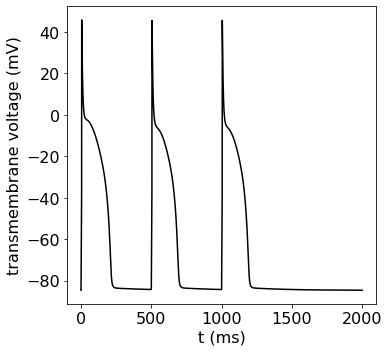

In [56]:
#voltage
fontsize=16
save=True

plt.subplots(figsize=(5.5,5))
plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
# plt.xlim([-10,300])
plt.ylabel('transmembrane voltage (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_voltage_optimized.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

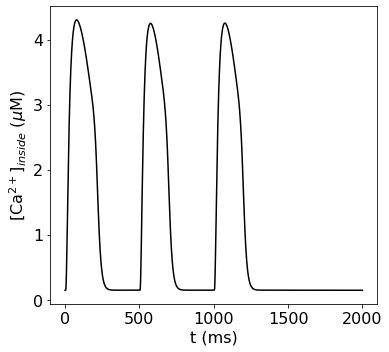

In [58]:
#calcium
fontsize=16
save=True
plt.subplots(figsize=(5.5,5))
plt.plot(t_values,Ca_i_values*10**+6,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
# plt.xlim([-10,200])
# plt.xlim([-10,300])
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel(r'[Ca$^{2+}]_{inside}$ ($\mu$M)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    savefig_fn='LR_model_calcium_optimized.png'
    plt.savefig(savefig_fn,dpi=300)

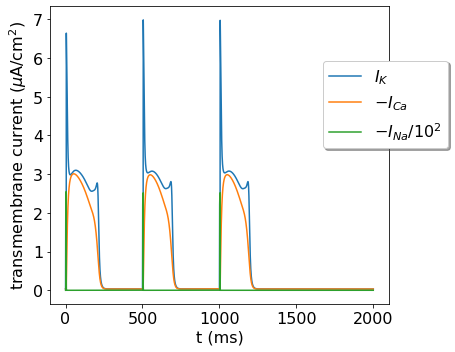

In [59]:
## plot current versus t
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,IK_values,label=r'$I_{K}$')#,alpha=0.7)
plt.plot(t_values,-ICa_values,label=r'$-I_{Ca}$')#,alpha=0.7)
plt.plot(t_values,-INa_values/10**2,label=r'$-I_{Na}/10^2$')

plt.legend(ncol=1, fontsize=fontsize,loc='right', bbox_to_anchor=(1.2,.67), fancybox=True, shadow=True)
# plt.yscale('log')
# plt.xlim([-10,300])
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane current ($\mu$A/cm$^2$)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_AP_current_optimized.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

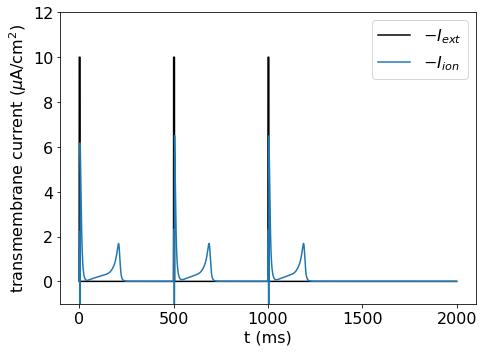

In [61]:

## plot current versus t
fontsize=16
save=False
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,-Istim_values,c='k',label=r'$-I_{ext}$')
plt.plot(t_values,Iion_values,label=r'$-I_{ion}$')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
# plt.xlim([-10,300])
plt.legend(fontsize=fontsize)
plt.ylim([-1,12])
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane current ($\mu$A/cm$^2$)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    savefig_fn='LR_model_current_stim_optimized.png'
    plt.savefig(savefig_fn,dpi=300)

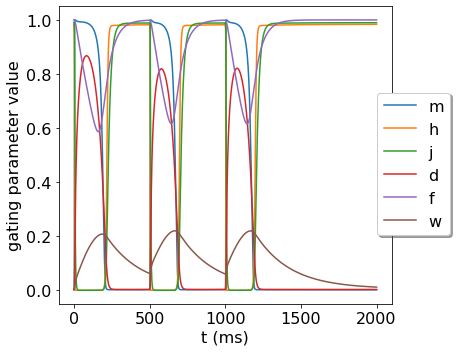

In [62]:
#plot gating variables versus t
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,m_values,label='m')
plt.plot(t_values,h_values,label='h')
plt.plot(t_values,j_values,label='j')
plt.plot(t_values,d_values,label='d')
plt.plot(t_values,f_values,label='f')
plt.plot(t_values,x_var_values,label='w')
plt.legend(ncol=1, fontsize=fontsize,loc='right', bbox_to_anchor=(1.2,.47), fancybox=True, shadow=True)
# plt.yscale('log')
# plt.xlim([-10,300])

plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('gating parameter value', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_AP_gating_params_optimized.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [63]:
# plt.ylabel('channel rates (1/ms)', fontsize=fontsize)

In [64]:
beep(2)

0

In [65]:
df=pd.DataFrame({
    't':t_values,
    'V':V_values,
    'Ca_i':Ca_i_values,
    'INa':INa_values,
    'IK' :IK_values,
    'ICa':ICa_values,
    'Istim':Istim_values,
    'm':m_values,
    'h':h_values,
    'j':j_values,
    'd':d_values,
    'f':f_values,
    'x_var':x_var_values,
})

In [66]:
# os.chdir(nb_dir)
os.chdir(os.path.join(nb_dir,'Figures/methods'))
df.to_csv('LR_action_potentials_optimized.csv')

# AP from the FK model in 0D
comparing to a simpler model...

## define the FK model

__The Difference between param_set_8 (wj's alteration) and param_set_8_og is that the fast (sodium) current repolarizes much faster in wj's alteration, which has the effect of a more consistent wavefront amplitude.__

In [35]:
# step function
@njit
def step(a,b):
    return 1 if a<=b else 0 # nan yields 1
@njit
def Tanh(x):
    return np.math.tanh(x)

@njit
def mycomp_flow_map_FK(V, f, s):#, h):
    C_m      = 1.000  #µF membrane capacitance determined by gap junctions between myocardial cells

    #parameter set 8 of FK model from Fenton & Cherry (2002)
    tau_pv   = 13.03
    tau_v1   = 19.6
    tau_v2   = 1250
    tau_pw   = 800
    tau_mw   = 40
    tau_d    = 0.45# also interesting to try, but not F&C8's 0.45: 0.407#0.40#0.6#
    tau_0    = 12.5
    tau_r    = 33.25
    tau_si   = 29#
    K        = 10
    V_sic    = 0.85#
    V_c      = 0.13
    V_v      = 0.04
    C_si     = 1  # I didn't find this (trivial) multiplicative constant in Fenton & Cherry (2002).  The value C_si = 1 was used in Kaboudian (2019).

    #wj's alteration... what effect does it have on APD??
    tau_v2   = 19.6
    tau_v1   = 1250
    
    
    vlt = V#volts
    fig = f#fast var
    sig = s#slow var

    p = step(V_c, vlt)
    q = step(V_v, vlt)
    
    #original FK model
    #     tau_mv = (1.0 - q) * tau_v1 + q * tau_v2
    #FK model with tau_v2 and tau_v1 switched
    tau_mv = (1.0 - q) * tau_v2 + q * tau_v1
    
    Ifi = -fig * p * (vlt - V_c) * (1.0 - vlt) / tau_d
    Iso = vlt * (1.0 - p) / tau_0 + p / tau_r

    tn = Tanh(K * (vlt - V_sic))
    Isi = -sig * (1.0 + tn) / (2.0 * tau_si)
    Isi *= C_si
    dFig2dt = (1.0 - p) * (1.0 - fig) / tau_mv - p * fig / tau_pv
    dSig2dt = (1.0 - p) * (1.0 - sig) / tau_mw - p * sig / tau_pw

#     I_sum = Isi + Ifi + Iso
#     dVlt2dt -= I_sum / C_m
    return Isi , Ifi , Iso, dFig2dt, dSig2dt

## Simulation of three externally stimulated 0D action potentials from the FK model 
using the lookup table generated by `gener_table.py`

In [36]:
dt=0.1 #ms
#initialize the resting state of local model
V, F, S=(0.,1.,1.)
# V, F, S=(0.,0.,1.)
#initialize methods
Cm=1. # µF membrane capacitance determined by gap junctions between myocardial cells

tf = 2000#up to 2 seconds
count=0.
dur=10.
mag=-4./(35--85)#-3./(35--85)#-.03#-3.
# forward integrate to tf
num_time_steps=int(tf/dt)
t_values=np.array([j*dt for j in range(num_time_steps)])
#forward euler integrate V to time t, saving all dynamic values
V_lst = [];F_lst=[];S_lst=[]
Isi_lst=[];Ifi_lst=[];Iso_lst=[];Istim_lst=[];Iion_lst=[]
for t in t_values:
    #compute flow map
    Isi , Ifi , Iso, dFdt, dSdt = mycomp_flow_map_FK(V, F, S)
    Iion = Isi + Ifi + Iso


    #compute external stimulus
    if ((t>50.) & (t<50.+dur))|((t>550.) & (t<550.+dur))|((t>1050.) & (t<1050.+dur)):
        Istim=mag
    else:
        Istim=0.
    dVdt = -(Iion+Istim) / Cm

    
    #record time and variables
    V_lst.append(V);F_lst.append(F);S_lst.append(S)
    Isi_lst.append(Isi);Ifi_lst.append(Ifi);Iso_lst.append(Iso);Istim_lst.append(Istim);Iion_lst.append(Iion)
    
    #integrate in time
    V+=dt*dVdt
    F+=dt*dFdt
    S+=dt*dSdt
    
    #update time
    t+=dt
    count+=1
#     printProgressBar(count,num_time_steps)
V_values=np.array(V_lst)
#gating values
F_values=np.array(F_lst)
S_values=np.array(S_lst)
#current values
Isi_values=np.array(Isi_lst)
Ifi_values=np.array(Ifi_lst)
Iso_values=np.array(Iso_lst)
Istim_values=np.array(Istim_lst)
Iion_values=np.array(Iion_lst)
beep(1)

0

### plot action potential 

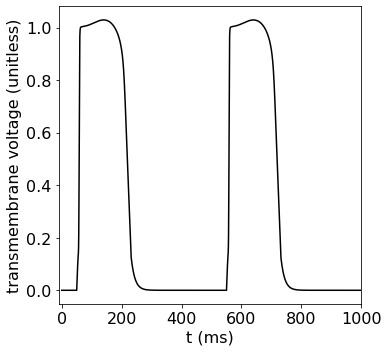

In [37]:
savefig_fn='FK_model_voltage_optimized_wj.png'
# savefig_fn='FK_model_voltage_optimized.png'
#voltage
fontsize=16
save=True

plt.subplots(figsize=(5.5,5))
# plt.plot(t_values,V_values*(35--85)-85,c='k')#mV
plt.plot(t_values,V_values,c='k')#unitless
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane voltage (unitless)', fontsize=fontsize)
plt.xlim([-10,1000])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

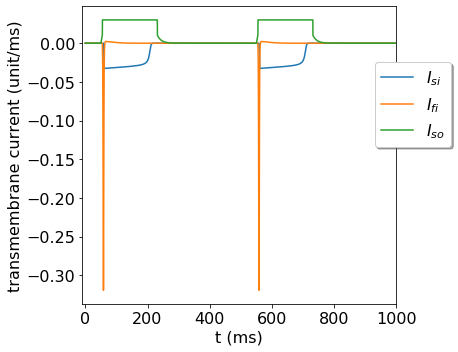

In [38]:
savefig_fn='FK_AP_current_optimized_wj.png'
# savefig_fn='FK_AP_current_optimized.png'
## plot current versus t
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,Isi_values,label=r'$I_{si}$')#,alpha=0.7)
plt.plot(t_values,Ifi_values,label=r'$I_{fi}$')#,alpha=0.7)
plt.plot(t_values,Iso_values,label=r'$I_{so}$')

plt.xlim([-10,1000])
plt.legend(ncol=1, fontsize=fontsize,loc='right', bbox_to_anchor=(1.2,.67), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane current (unit/ms)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

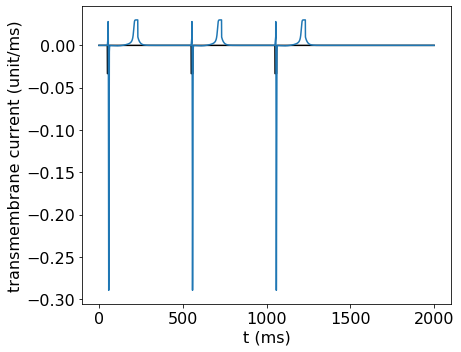

In [39]:
savefig_fn='FK_model_current_stim_optimized_wj.png'
# savefig_fn='FK_model_current_stim_optimized.png'

## plot current versus t
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,Istim_values,c='k')
plt.plot(t_values,Iion_values)
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
# plt.yscale('log')
# plt.xlim([-10,200])
# plt.ylim([-4,6])
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('transmembrane current (unit/ms)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

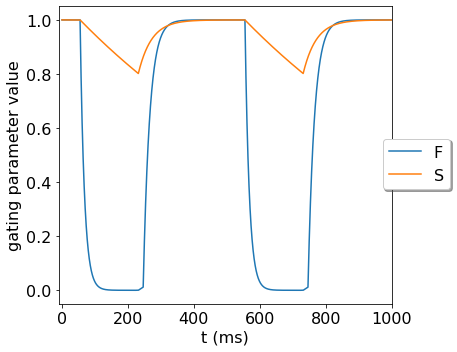

In [40]:
savefig_fn='FK_AP_gating_params_optimized_wj.png'
# savefig_fn='FK_AP_gating_params_optimized.png'

#plot gating variables versus t
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,F_values,label='F')
plt.plot(t_values,S_values,label='S')
plt.legend(ncol=1, fontsize=fontsize,loc='right', bbox_to_anchor=(1.2,.47), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('gating parameter value', fontsize=fontsize)
plt.xlim([-10,1000])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [30]:
# plt.ylabel('channel rates (1/ms)', fontsize=fontsize)

In [31]:
beep(2)

0

In [41]:
df=pd.DataFrame({
    't':t_values,
    'V':V_values,
    'Isi':Isi_values,
    'Ifi' :Ifi_values,
    'Iso':Iso_values,
    'Istim':Istim_values,
    'F':F_values,
    'S':S_values,
})

In [42]:
# os.chdir(nb_dir)
os.chdir(os.path.join(nb_dir,'Figures/methods'))
df.to_csv('FK_action_potentials_optimized_wj.csv')
# df.to_csv('FK_action_potentials_optimized.csv')

# (ignore) scratchwerk

## DONE: test time steps initial tip measurements

## define some time step functions

In [ ]:
# def get_compute_dtxtdt(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
#                        Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,method='njit'):
#     if method=='njit':
#         njitsu = njit
#     if method=='cuda':
#         import numba.cuda.njit as njitsu
#     comp_rate_of_change_at_pixel_LR=get_comp_rate_of_change_at_pixel_LR(ds = ds, width = width, height = height, Cm=Cm, diffCoef=diffCoef,
#                                                                         Na_i = Na_i, Na_o = Na_o, K_i  = K_i, K_o  = K_o, Ca_o = Ca_o,method='njit')
#     @njitsu
#     def compute_dtxtdt(txt,out):
#         for x in range(width):
#             for y in range(height):
#                 out[x,y] = comp_rate_of_change_at_pixel_LR(txt, x, y)
#     return compute_dtxtdt

In [ ]:
# def get_one_step_forward_euler(txt,compute_dtxtdt,method='njit'):
#     '''Exception ZeroDivisionError: division by zero may be thrown if V becomes larger than 10000. mV.  Consider lowering time step for stability.'''
#     if method=='njit':
#         njitsu = njit
#     if method=='cuda':
#         import numba.cuda.njit as njitsu
#     zero_txt = np.zeros_like(txt)

#     @njitsu
#     def one_step_forward_euler(txt,dt):
#         dtxt_dt=zero_txt.copy()
#         compute_dtxtdt(txt,out=dtxt_dt)
#         txt += dt*dtxt_dt
    
#     return one_step_forward_euler

In [ ]:
# def get_multi_step_forward_euler(txt,compute_dtxtdt,method='njit'):
#     '''Exception ZeroDivisionError: division by zero may be thrown if V becomes larger than 10000. mV.  Consider lowering time step for stability.'''
#     if method=='njit':
#         njitsu = njit
#     if method=='cuda':
#         import numba.cuda.njit as njitsu
#     one_time_step_forward_euler=get_one_step_forward_euler(txt,method='njit')
#     @njitsu
#     def multi_step_forward_euler(txt,numsteps=4,dt = 0.01):
#         for stepnum in range(numsteps):
#             one_time_step_forward_euler(txt, dt)
#         return txt
#     return multi_step_forward_euler

In [ ]:
# #for measurement
# @njit
# def interpolate_img(x_values,y_values,width,height,img):
#     '''Measure color of txt at zip(x_values,y_values).  This was used to measure EP states.
#     Example Usage:
#     v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
#     '''
#     states_bilinear_lst = []
#     for x,y in zip(x_values,y_values):
#         states_bilinear = bilinear_interpolate_channel(x,y,width,height,img)
#         states_bilinear_lst.append(states_bilinear)
#     return states_bilinear_lst

# @njit
# def ___pbc_1d(x_in,width):
#     if np.greater_equal(x_in , width):
#         return int(x_in-width)
#     elif np.less(x_in, 0):
#         return int(x_in+width)
#     return int(x_in)

# @njit
# def bilinear_interpolate_channel(x,y,width,height,img):
#     r0 = np.floor(y)
#     r1 = np.ceil(y)
#     frac_r = y-r0
#     if r0==r1:
#         r1+=1
#     c0 = np.floor(x)
#     c1 = np.ceil(x)
#     frac_c = x-c0
#     if c0==c1:
#         c1+=1
#     c0 = ___pbc_1d(c0,width)
#     c1 = ___pbc_1d(c1,width)
#     r0 = ___pbc_1d(r0,height)
#     r1 = ___pbc_1d(r1,height)
#     a11 = img[r0,c0]
#     a21 = img[r1,c0]-a11
#     a12 = img[r0,c1]-a11
#     a22 = img[r1,c1]-a11-a12-a21
#     states_bilinear = a11 + a21*frac_c + a12*frac_r + a22*frac_c*frac_r
#     return states_bilinear

In [ ]:
# one_step_kernel_LR=get_one_step_kernel_LR_forward_euler(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
#                        Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8, method='njit')

In [ ]:
#test scaling from mV to dimensionless voltage for plotting
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
zero_txt = np.zeros_like(txt)
txt_plt = get_voltage_field_scaled_and_shifted(txt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
assert np.isclose(np.max(txt_plt),1.,atol=1e-1)
assert np.isclose(np.min(txt_plt),0.,atol=1e-10)

# #get jit compiling functions
# compute_dtxtdt = get_compute_dtxtdt(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
#                        Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,method='njit')
# one_step_forward_euler = get_one_step_forward_euler(txt,compute_dtxtdt)
# multi_step_forward_euler = get_multi_step_forward_euler(txt,compute_dtxtdt)

In [ ]:
# #global tests for discrete flow map
# txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
# dtxt_dt=zero_txt.copy()
# compute_dtxtdt(txt,out=dtxt_dt)
# assert (dtxt_dt.shape==txt.shape)
# assert not np.isnan(txt).any()
# assert not np.isnan(dtxt_dt).any()

In [ ]:
multi_step_forward_euler=get_multi_step_forward_euler()

In [ ]:
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
t=0.
dt=0.000001
half_num_steps=400
count=0.
inVc=txt[...,(0,-1)].copy()
inmhjdfx=txt[...,1:-1].copy()
outVc=inVc.copy()
dVcdt=inVc.copy()
outmhjdfx=inmhjdfx.copy()
# multi_step_forward_euler(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt,half_num_steps)
for bob in range(half_num_steps):
    one_step_kernel_LR(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt)
    inVc=outVc.copy()
    inmhjdfx=outmhjdfx.copy()
#     one_step_kernel_LR(outVc,inVc,outmhjdfx,inmhjdfx,dVcdt,dt)
    t+=dt
    count+=1
    printProgressBar(count,half_num_steps)
beep(1)

In [ ]:
#test comp_gating_constants
comp_gating_constants=get_comp_gating_constants()
V = np.min(inVc)
retval=comp_gating_constants(V)
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x, m_infty, h_infty, j_infty, d_infty, f_infty, x_infty=retval
# assert retval.shape[0]==12
print(f'time scales at smallest voltage, {V} mV,')
print(tau_m, tau_h, tau_j, tau_d, tau_f, tau_x,)

V = np.max(inVc)
retval=comp_gating_constants(V)
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x, m_infty, h_infty, j_infty, d_infty, f_infty, x_infty=retval
# assert retval.shape[0]==12
print(f'time scales at largest voltage, {V} mV,')
print(tau_m, tau_h, tau_j, tau_d, tau_f, tau_x,)

In [ ]:
comp_ionic_currents = get_comp_ionic_currents()#K_i=K_i,K_o=K_o,ENa=54.4,EK=-77.0,method=method,**kwargs)
outIion = inVc[...,0].copy()
for x in range(200):
    for y in range(200):
        C = inmhjdfx[x,y]
        V,Ca_i = inVc[x,y]
        m = C[0] #activation gate parameter (Na)
        h = C[1] #fast inactivation gate parameter (INa)
        j = C[2] #slow inactivation gate parameter (INa)
        d = C[3] #activation gate parameter (Isi)
        f = C[4] #inactivation gate parameter (Isi)
        x_var = C[5] #activation gate parameter (IK)
        Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)
        outIion[x,y]=Iion

In [ ]:
plt.hist(outIion.flatten(),bins=50)
plt.show()

In [ ]:
plt.hist(outmhjdfx[...,1].flatten(),bins=50)
plt.show()

## DONE: visualize tips detected 

In [ ]:
#TODO: visualize txt after integrating by one_time_step_forward_euler a few times
# V_threshold=0.4
# theta_threshold=0.
# txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
# width,height=txt.shape[:2]
# dtxt_dt=zero_txt.copy()
# compute_dtxtdt(txt,out=dtxt_dt)
# img=txt[...,0]
# dimgdt=dtxt_dt[...,0]
# img1 = get_voltage_field_scaled_and_shifted(txt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
# img2 = get_voltage_field_scaled_and_shifted(txt_nxt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
# dimgdt=get_voltage_field_scaled_and_shifted(dtxt_dt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
#TODO: take theta_threshold out of the njit'd steps
#TODO(later, after validating): comp_next_time_step(dt_prev, dV)

#V_FK = 0.4 roughly corresponds to V_LR = -37 mV??
# V_LR = -37 mV??
#V_LR = 0. mV roughly corresponds to V_FK=0.4??
# (87-37)/(87+35) 
# get_voltage_field_scaled_and_shifted(np.array([0.1,0.1]), Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)

In [ ]:
V_threshold=0.#-37.#mV
level1=V_threshold
theta_threshold=0.
level2=0.
img=inVc[...,0]
dimgdt=dVcdt[...,0]
width=200;height=200

#compute all spiral tips present
t = -999.


# level2=V_threshold
retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
# retval = find_intersections(img1,img2,level1,level2,theta_threshold=theta_threshold)
lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
x_values = np.array(lst_values_x)
y_values = np.array(lst_values_y)
# EP states given by bilinear interpolation with periodic boundary conditions
v_lst    = interpolate_img(x_values,y_values,width,height,img=img)
dvdt_lst = interpolate_img(x_values,y_values,width,height,img=dimgdt)

n_tips = x_values.size
dict_out = {
    't': float(t),
    'n': int(n_tips),
    'x': tuple(lst_values_x),
    'y': tuple(lst_values_y),
    'theta': tuple(lst_values_theta),
    'grad_ux': tuple(lst_values_grad_ux),
    'grad_uy': tuple(lst_values_grad_uy),
    'grad_vx': tuple(lst_values_grad_vx),
    'grad_vy': tuple(lst_values_grad_vy),
    'v':v_lst,
#     'f':f_lst,
#     's':s_lst,
    'dvdt':dvdt_lst,
#     'dfdt':dfdt_lst,
#     'dsdt':dsdt_lst,
}
dict_out_instant=dict_out
print(dict_out['n'])
# lst_values_theta

In [ ]:
np.min(dimgdt)
np.max(dimgdt)

In [ ]:
c_values=np.array(dict_out['dvdt'])
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
plt.show(fig)

## DONE: test forward euler integration

In [ ]:
# TODO: retry timestepping with (i) smaller time step or (ii) finer spatial discretization
get_multi_step_forward_euler(txt,compute_dtxtdt,method='njit')

In [ ]:
#force comp_gating_constants to not raise divide by zero errors for large V

In [ ]:
# DONE: Visualize I vs. V curves and verify they agree with Qu2000 or Luo1990

In [ ]:
# tau_m
tau_h
# tau_x

In [ ]:
tau_d

## DONE: use the lookup_table to compute $I_{ion}$

In [ ]:
#generate lookup tables for timestep
dt = 0.01
os.chdir(os.path.join(nb_dir,'lib/model'))
cmd=f"python3 gener_table.py {dt}"
os.system(cmd)
#load lookup table for timestep
os.chdir(os.path.join(nb_dir,'lib/model','lookup_tables'))
table_fn=f"luo_rudy_dt_{dt}.npz"
table_data=np.load(table_fn)
print(f'loaded from {table_fn} the arrays:')
for item in table_data.get('kwds'):
    print(item)

In [ ]:
#convert table_data to a set of pandas.DataFrame instances
kwds=table_data.get('kwds')
cols=kwds[-1].split('_')[1:]
keys=list(table_data.keys())
arr39=table_data[keys[-1]].T
print(np.array(cols[1:]))

In [ ]:
# df39=pd.DataFrame(arr39,columns=cols)
# v_values=df39.v.values

In [ ]:
#DONE: perform linear interpolation for a given input voltage
#DONE: compute the neighboring rows, m, m+1
#DONE: linearly interpolate between ^those rows
#DONE: get model parameters from ^that


In [ ]:
# def get_comp_v_row(v_values):
#     dv=np.around(np.mean(np.diff(v_values)),1)
#     v0=np.min(v_values)
#     @njit
#     def comp_v_row(v):
#         return int((v-v0)/dv)
#     return comp_v_row

# def get_lookup_params(v_values,dv=0.1):
#     comp_row=get_comp_row(v_values)
#     @njit
#     def lookup_params(V,arr39):
#         M=comp_row(V)
#         arr=arr39[M:M+2]
#         Vlo=arr[0,0]
#         frac=(V-Vlo)/dv
#         arr_interp=frac*arr[1,:]+(1.-frac)*arr[0,:]
#         # assert ( np.isclose( arr_interp[0]-V, 0.))#passed
#         return arr_interp
#     return lookup_params

In [ ]:
#test get row
v_values=arr39[:,0]
comp_v_row=get_comp_v_row(v_values)
lookup_params=get_lookup_params(v_values,dv=0.1)
assert(comp_row(-100)==0)
assert(comp_row(-99.9)<2)
assert(comp_row(-99.89)==1)

In [ ]:
# @njit
# def comp_soln_gating_var(var, varinfty, evar):
# 	return varinfty - (varinfty-var)*evar

In [ ]:
# lookup_params=get_lookup_params(v_values,dv=0.1)
# V=-35.6587

    
# #parse the linearly interpolated row
# arr_interp=lookup_params(V,arr39)
# # x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]

# #parse the linearly interpolated row
# x_infty =arr_interp[1]    # 'xinf1', 
# # tau_x =arr_interp[2]    # 'xtau1', 
# m_infty=arr_interp[3]    # 'xinfm', 
# # tau_m=arr_interp[4]    # 'xtaum', 
# h_infty=arr_interp[5]    # 'xinfh', 
# # tau_h=arr_interp[6]    # 'xtauh', 
# j_infty=arr_interp[7]    # 'xinfj',
# # tau_j=arr_interp[8]    # 'xtauj', 
# d_infty=arr_interp[9]    # 'xinfd', 
# # tau_d=arr_interp[10]    # 'xtaud', 
# f_infty=arr_interp[11]    # 'xinff', 
# # tau_f=arr_interp[12]    # 'xtauf', 
# IK1T=arr_interp[13]    # 'xttab', total time indep potassium current
# x1=arr_interp[14]    # 'x1', 
# e1=arr_interp[15]    # 'e1',
# em=arr_interp[16]    # 'em', 
# eh=arr_interp[17]    # 'eh', 
# ej=arr_interp[18]    # 'ej',
# ed=arr_interp[19]    # 'ed', 
# ef=arr_interp[20]    # 'ef'

In [ ]:
# def get_lookup_params(v_values,dv=0.1):
#     comp_row=get_comp_row(v_values)
#     @njit
#     def lookup_params(V,arr39):
#         M=comp_row(V)
#         arr=arr39[M:M+2]
#         Vlo=arr[0,0]
#         frac=(V-Vlo)/dv
#         arr_interp=frac*arr[1,:]+(1.-frac)*arr[0,:]
#         # assert ( np.isclose( arr_interp[0]-V, 0.))#passed
#         return arr_interp
#     return lookup_params

In [ ]:
# v=0
# vx1=-77.62;xk0=5.4
# gx1=0.423*2.837*sqrt(5.4/xk0)
# fac=exp(0.04*(v+77.))
# fac1=(v+77.)*exp(0.04*(v+35.))
# x1=gx1*(v-vx1)*(fac-1.)/fac1

In [ ]:
# gx1

In [ ]:
# @njit
# def comp_exact_next_gating_var(inCgate,outCgate,arr_interp):
#     """returns updated  gating variables"""
#     m = inCgate[0] #activation gate parameter (Na)
#     h = inCgate[1] #fast inactivation gate parameter (INa)
#     j = inCgate[2] #slow inactivation gate parameter (INa)
#     d = inCgate[3] #activation gate parameter (Isi)
#     f = inCgate[4] #inactivation gate parameter (Isi)
#     x_var = inCgate[5] #activation gate parameter (IK)

#     #parse the linearly interpolated row
#     x_infty =arr_interp[1]    # 'xinf1', 
#     # tau_x =arr_interp[2]    # 'xtau1', 
#     m_infty=arr_interp[3]    # 'xinfm', 
#     # tau_m=arr_interp[4]    # 'xtaum', 
#     h_infty=arr_interp[5]    # 'xinfh', 
#     # tau_h=arr_interp[6]    # 'xtauh', 
#     j_infty=arr_interp[7]    # 'xinfj',
#     # tau_j=arr_interp[8]    # 'xtauj', 
#     d_infty=arr_interp[9]    # 'xinfd', 
#     # tau_d=arr_interp[10]    # 'xtaud', 
#     f_infty=arr_interp[11]    # 'xinff', 
#     # tau_f=arr_interp[12]    # 'xtauf', 
#     #     IK1T=arr_interp[13]    # 'xttab', 
#     x1=arr_interp[14]    # 'x1', 
#     e1=arr_interp[15]    # 'e1',
#     em=arr_interp[16]    # 'em', 
#     eh=arr_interp[17]    # 'eh', 
#     ej=arr_interp[18]    # 'ej',
#     ed=arr_interp[19]    # 'ed', 
#     ef=arr_interp[20]    # 'ef'

#     outCgate[0]=comp_soln_gating_var(m,m_infty, em)
#     outCgate[1]=comp_soln_gating_var(h,h_infty, eh)
#     outCgate[2]=comp_soln_gating_var(j,j_infty, ej)
#     outCgate[3]=comp_soln_gating_var(d,d_infty, ed)
#     outCgate[4]=comp_soln_gating_var(f,f_infty, ef)
#     outCgate[5]=comp_soln_gating_var(x_var,x_infty, e1)  
    
# def get_comp_ionic_flux(GNa=16.,GK1=0.6047,Gsi=0.052,EK1=-87.94,Eb=-59.87,ENa=54.4):#,GK=0.423
#     # #maximum conductances
#     # GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
#     # GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
#     # Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
#     # GK  = 0.423   #mS/cm^2 #from Qu2000.pdf
#     # #reversal potentials
#     # EK1 = -87.94 #mV
#     # EKp = EK1    #mV
#     # Eb  = -59.87 #mV
#     # ENa = 54.4   #mV
#     @njit
#     def comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i):
#         """returns updated  gating variables"""
#         m = inCgate[0] #activation gate parameter (Na)
#         h = inCgate[1] #fast inactivation gate parameter (INa)
#         j = inCgate[2] #slow inactivation gate parameter (INa)
#         d = inCgate[3] #activation gate parameter (Isi)
#         f = inCgate[4] #inactivation gate parameter (Isi)
#         x_var = inCgate[5] #activation gate parameter (IK)
#         #Fast sodium current
#         INa = GNa*m**3*h*j*(V-ENa)
#         #Slow inward current
#         Esi=7.7-13.0287*np.log(Ca_i)#mV
#         Isi=Gsi*d*f*(V-Esi)
#         #time dependent potassium current 
#         IK=x_var*x1#GK*x_var*x1
#         #total electric current
#         Iion=INa+IK1T+Isi+IK
#         #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
#         dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)
#         return Iion, dCa_i_dt#INa,IK1T,Isi,IK# GNa,m**3*h*j,(V-ENa)#,#
#     return comp_ionic_flux

In [ ]:
#DONE: initialize gating variables to literally anything
#DONE: compute local Isi, IKT, INa.  compute Iion.
#DONE: compute local change in Ca_i
#DONE: compute local next values of gating variables with the exact flow map
# comp_ionic_flux=get_comp_ionic_flux()
# comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
# Sodium current is what's causing enormous currents 

In [ ]:
# #compute local next values of gating variables with the exact flow map
# inCgate=np.array([0,0,0,0,0,0])
# outCgate=inCgate.copy()

# V=-35.6587
# #parse the linearly interpolated row
# arr_interp=lookup_params(V,arr39)
# comp_exact_next_gating_var(inCgate,outCgate,arr_interp)

In [ ]:
# comp_ionic_flux=get_comp_ionic_flux()

In [ ]:
# Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)

In [ ]:
# Iion, dCa_i_dt=comp_ionic_flux(inCgate,arr_interp)

WJ has an extra factor of (v-vx1) in computing x1?

Yes, but this should be considered when computing I_K

$$
I_K = x* x1_{WJ}
$$

In [ ]:
#TODO: compute dVdt
#TODO: wrap all ^this in a kernel using the operator splitting method described in Qu2000.
#TODO: compute next time step 
#TODO: implement adaptive time stepping using a priority queue
#TODO: initialize time buffer.  initialize dt buffer
#TODO: get interpolated values for a given dt by using a lookup table of lookup tables

$$
ey \equiv \exp(-\Delta t/\tau_m(V))
$$

my implementation was exploding because I wasn't adding $I_K$ to $I_{ion}$.

In [ ]:
#sorted lookup table of sorted lookup tables, all given in terms of numpy arrays

## DONE: compute dVdt
using splitting method as described in Qu1999.pdf

In [ ]:
#TODO: compute dVdt
# input_file_name=search_for_file()
# print ( input_file_name )

input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
inVmhjdfxc = load_buffer_LR(input_file_name)
txt=inVmhjdfxc
zero_txt = np.zeros_like(txt)
width,height,chnlno = txt.shape
print (f"buffer dimensions are width, height, chnlno = { width,height,chnlno }.") 

In [ ]:
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
t=0.
dt=0.01
half_num_steps=40
count=0.
inVc=txt[...,(0,-1)].copy()
inmhjdfx=txt[...,1:-1].copy()
outVc=inVc.copy()
dVcdt=inVc.copy()
outmhjdfx=inmhjdfx.copy()
# multi_step_forward_euler(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt,half_num_steps)
for bob in range(half_num_steps):
    one_step_kernel_LR(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt)
    inVc=outVc.copy()
    inmhjdfx=outmhjdfx.copy()
#     one_step_kernel_LR(outVc,inVc,outmhjdfx,inmhjdfx,dVcdt,dt)
    t+=dt
    count+=1
    printProgressBar(count,half_num_steps)
beep(1)

In [ ]:
# def get_comp_one_step_kernel_LR_forward_euler(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
#                        Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,method='njit'):
#     if method=='njit':
#         njitsu = njit
#     if method=='cuda':
#         import numba.cuda.njit as njitsu
#     comp_rate_of_voltage_change_at_pixel_LR=get_comp_rate_of_voltage_change_at_pixel_LR(ds = ds, width = width, height = height, Cm=Cm, diffCoef=diffCoef,
#                                                                         Na_i = Na_i, Na_o = Na_o, K_i  = K_i, K_o  = K_o, Ca_o = Ca_o,method=method)
#     comp_exact_flow_map_gating_variables=get_comp_exact_flow_map_gating_variables(method=method)
#     # pbc=get_pbc(width,height)

#     @njitsu
#     def comp_one_step_kernel_LR_forward_euler(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt):
#         for x in range(width):
#             for y in range(height):
#                 # x,y = pbc(x,y)
#                 C = inVc[x,y]
#                 inCgate = inmhjdfx[x,y]
#                 outCgate = outmhjdfx[x,y]
#                 V = C[0]
#                 #update gating variables with next value
#                 comp_exact_flow_map_gating_variables(inCgate, outCgate, V, dt)
#                 #compute current at pixel using gating variables evaluated according to the implicit midpoint rule
#                 Cgate=0.5*inCgate+0.5*outCgate
#                 dVcdt_val = comp_rate_of_voltage_change_at_pixel_LR(inVc, C, Cgate, x, y)
#                 dVcdt[x,y] = dVcdt_val
#                 outVc[x,y] = C + dt*dVcdt_val
#     return compute_one_step_kernel_LR_forward_euler

In [ ]:
# def get_comp_dVcdt(width=200,height=200,diffCoef=0.001,ds=0.025,Cm=1.):
#     comp_ionic_flux=get_comp_ionic_flux()
#     #spatial discretization
#     cddx = width  / ds  #if this is too big than the simulation will blow up (at a given timestep)
#     cddy = height / ds #if this is too big than the simulation will blow up (at a given timestep)
#     cddx *= cddx
#     cddy *= cddy
#     @njit
#     def comp_dVcdt(inVc,x,y,inCgate,IK1T,x1):
#         V,Ca_i = inVc[x,y].T
#         # Compute Ionic Current Density
#         Iion, dCa_i_dt=comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
#         # Compute transient term for transmembrane voltage
#         dVltdt  = laplacian(inVc, x, y, cddx, cddy, V)
#         dVltdt *= float(diffCoef)
#         dVltdt -= float(Iion/Cm)
#         dVcdt_val=np.array([dVltdt,dCa_i_dt],dtype=np.float64)
#         return dVcdt_val
#     return comp_dVcdt

In [ ]:
# def get_arr39(dt):
#     cwd=os.getcwd()
#     #generate lookup tables for timestep
#     os.chdir(os.path.join(nb_dir,'lib/model'))
#     cmd=f"python3 gener_table.py {dt}"
#     os.system(cmd)
#     #load lookup table for constant timestep, dt.
#     os.chdir(os.path.join(nb_dir,'lib/model','lookup_tables'))
#     table_fn=f"luo_rudy_dt_{dt}.npz"
#     table_data=np.load(table_fn)    
#     #convert table_data to a numpy array
#     kwds=table_data.get('kwds')
#     cols=kwds[-1].split('_')[1:]
#     keys=list(table_data.keys())
#     arr39=table_data[keys[-1]].T  
#     #return to original working directory
#     os.chdir(cwd)
#     return arr39

In [ ]:
# def get_one_step_explicit_synchronous_splitting(nb_dir,dt=0.01,width=200,height=200,ds=5.,diffCoef=0.001,Cm=1.):
#     '''returns dt, arr39, one_step_explicit_synchronous_splitting
#     precomputes lookup table, arr39 and returns a jit compiling one_step method
#     '''
#     #precompute lookup table
#     arr39=get_arr39(dt,nb_dir)
#     v_values=arr39[:,0]
#     lookup_params=get_lookup_params(v_values,dv=0.1)
#     comp_dVcdt=get_comp_dVcdt(width=width, height=height, diffCoef=diffCoef, ds=ds, Cm=Cm)

#     @njit
#     def one_step_explicit_synchronous_splitting(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt):
#         '''
#         for each pixel:
#             advances V and Ca_i by dt/2 for each pixel using forward euler integration
#         and then,
#         for each pixel:
#             advances gating variables using the exact flow map resulting from V
#             advances V and Ca_i by dt/2 for each pixel using forward euler integration
#         enforces agreement between inVc and outVc and between inmhjdfx and outmhjdfx (to avoid any confusion)
#         '''
#         for x in range(width):
#             for y in range(height):
#                 #extract local variables
#                 Vc = inVc[x,y]; V=Vc[0]
#                 inCgate = inmhjdfx[x,y]

#                 #parse the row linearly interpolated from lookup table
#                 arr_interp=lookup_params(V,arr39)
#                 IK1T=arr_interp[13]    # 'xttab', 
#                 x1=arr_interp[14]    # 'x1', 

#                 #half step voltage and calcium
#                 dVcdt_val=comp_dVcdt(inVc, x, y, inCgate, IK1T, x1)
#                 outVc_val=Vc+0.5*dt*dVcdt_val
#                 outVc[x,y]=outVc_val      
#         for x in range(width):
#             for y in range(height):
#                 #parse the row linearly interpolated from lookup table with updated voltage
#                 inCgate  = inmhjdfx[x,y]
#                 outCgate = outmhjdfx[x,y]
#                 Vc = outVc[x,y]; V  = Vc[0]
#                 arr_interp=lookup_params(V,arr39)
#                 # x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
#                 IK1T=arr_interp[13]    # 'xttab', 
#                 x1=arr_interp[14]    # 'x1', 

#                 #full step the gating variables of step size dt (dt is encoded in arr39)
#                 comp_exact_next_gating_var(inCgate,outCgate,arr_interp)

#                 #half step voltage and calcium
#                 dVcdt_val=comp_dVcdt(outVc, x, y, inCgate, IK1T, x1)
#                 outVc_val=Vc+0.5*dt*dVcdt_val
#                 outVc[x,y]=outVc_val

#                 #record rate of change of voltage and calcium current
#                 dVcdt[x,y]=dVcdt_val
#                 inCgate=outCgate.copy()
#         #copy out to in
#         inmhjdfx=outmhjdfx.copy()
#         outVc=inVc.copy()
# #         t+=dt
#     return dt, arr39, one_step_explicit_synchronous_splitting

## DONE: Test the forward synchronous integration is stable

In [ ]:
#get one_step method
dt=0.1
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,dt=dt)

In [ ]:
#initialize simulation
t=0.
tf=2000.
num_steps=int(tf/dt)
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 45., Vmin = -75.)
inVc=txt[...,(0,-1)].copy()
inmhjdfx=txt[...,1:-1].copy()
outVc=inVc.copy()
dVcdt=inVc.copy()
outmhjdfx=inmhjdfx.copy()

In [ ]:
tf=2000.
num_steps=int(tf/dt)
count=0
for count in range(num_steps):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
    count+=1
    printProgressBar(count,num_steps)
beep(1)


In [ ]:
# plt.imshow(inVc[...,0],cmap='gray')


In [ ]:
# @njit   
def compute_all_spiral_tips(img,dimgdt,level1,level2,width=200,height=200):
    #compute all spiral tips present
    retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
    # level2=V_threshold
    # retval = find_intersections(img1,img2,level1,level2,theta_threshold=theta_threshold)
    lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
    return format_spiral_tips(lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, 
                              lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy) 
# @njit   
def format_spiral_tips(lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy):  
    x_values = np.array(lst_values_x)
    y_values = np.array(lst_values_y)
    # EP states given by bilinear interpolation with periodic boundary conditions
    v_lst    = interpolate_img(x_values,y_values,width,height,img=img)
    dvdt_lst = interpolate_img(x_values,y_values,width,height,img=dimgdt)

    n_tips = x_values.size
    dict_out = {
        't': float(t),
        'n': int(n_tips),
        'x': list(lst_values_x),
        'y': list(lst_values_y),
        'theta': list(lst_values_theta),
        'grad_ux': list(lst_values_grad_ux),
        'grad_uy': list(lst_values_grad_uy),
        'grad_vx': list(lst_values_grad_vx),
        'grad_vy': list(lst_values_grad_vy),
        'v':v_lst,
        'dvdt':dvdt_lst,
    }
    return dict_out

# TODO: test recording of spiral tips  at a particular voltage (forward euler method)

In [290]:
#DONE: retry from time t=200 with a larger time step

dt=0.01
h=0.1
#get one_step method
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,dt=dt)
dt, one_step_map = get_one_step_map(nb_dir,dt)

In [313]:
#initialize simulation
t=0.
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
#allocate memory
inVc=txt[...,(0,-1)].copy()
inmhjdfx=txt[...,1:-1].copy()
outVc=inVc.copy()
dVcdt=inVc.copy()
outmhjdfx=inmhjdfx.copy()
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)



In [314]:
#compute all spiral tips present
V_threshold=25.#mV
level1=V_threshold
# theta_threshold=0.
level2=0.
#take the first step
one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
t+=dt
img=inVc[...,0]
dimgdt=dVcdt[...,0]
width=200;height=200
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2,width=width,height=height)
dict_out_instantaneous=dict_out
print(np.max(inVc[...,0]))

35.34669132254096


0 tips are present at time t=0.


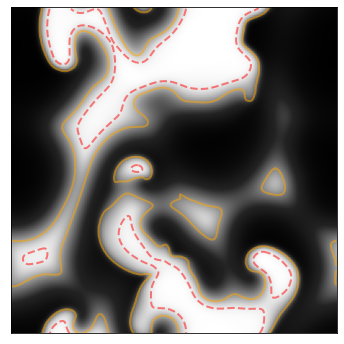

In [315]:
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['v'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
plt.show(fig)

In [316]:
#initialize simulation
t=0.
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
#allocate memory
inVc=txt[...,(0,-1)].copy()
inmhjdfx=txt[...,1:-1].copy()
outVc=inVc.copy()
dVcdt=inVc.copy()
outmhjdfx=inmhjdfx.copy()
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)



In [322]:
printing=True
h=0.1
#precompute anything that needs precomputing
dt=h/10.
tmax=100#25.#10.
#get one_step method
dt, one_step_map = get_one_step_map(nb_dir,dt)
# txt=one_step_map(txt)
num_steps=int((tmax-t)/dt)
step_count=0
if printing:
    #print(f"sigma is {sigma}, threshold is {threshold}.")
    #print(f"pad is {pad}, rejection_distance is edge_tolerance is {edge_tolerance}.")
    print(f"integrating to time t={tmax:.3f} ms without recording with dt={dt:.2f} ms.")
while (t<tmax):
    txt=one_step_map(txt)
    t+=dt
    step_count+=1
    printProgressBar(step_count,num_steps)
#     if n_tips==0:
#         print(f"zero tips remaining at time t={t}!")
#         break
beep(1)

integrating to time t=100.000 ms without recording with dt=0.01 ms.


0

In [323]:
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,dt=dt)

#check whether each field is getting updated
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt = unstack_txt(txt)
txt_ic=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 30., Vmin = -100.)
#allocate memory
inVc_ic=txt_ic[...,(0,-1)].copy()
inmhjdfx_ic=txt_ic[...,1:-1].copy()
outVc_ic=inVc_ic.copy()
dVcdt_ic=inVc_ic.copy()
outmhjdfx_ic=inmhjdfx_ic.copy()
one_step(inVc_ic,outVc_ic,inmhjdfx_ic,outmhjdfx_ic,dVcdt_ic)

print(np.max((inVc-inVc_ic)[...,1]))
print(np.min((inVc-inVc_ic)[...,1]))
print(np.max(outVc-outVc_ic))
print(np.min(outVc-outVc_ic))
print(np.max((inmhjdfx-inmhjdfx_ic)[...,5]))
print(np.min((inmhjdfx-inmhjdfx_ic)[...,5]))
print(np.max(outmhjdfx-outmhjdfx_ic))
print(np.min(outmhjdfx-outmhjdfx_ic))
print(np.max(dVcdt-dVcdt_ic))
print(np.min(dVcdt-dVcdt_ic))

-0.0008908661348184998
-0.005305501896522356
79.29553199765797
-113.48441701939954
0.23228147785661524
-0.14527958005140468
0.9798455721738227
-0.9994670392729137
22.21468810004081
-46.50441618307469


In [324]:
#update texture namespace
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
print(np.max(inVc[...,0]))
# dt

-13.27751006650329


In [325]:
#compute all spiral tips present
V_threshold=20.#10.#0.#mV
level1=V_threshold
# theta_threshold=0.
level2=0.

#update texture namespace
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

img=inVc[...,0]
width=200;height=200
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2,width=width,height=height)
dict_out_instantaneous=dict_out

0 tips are present at time t=100.


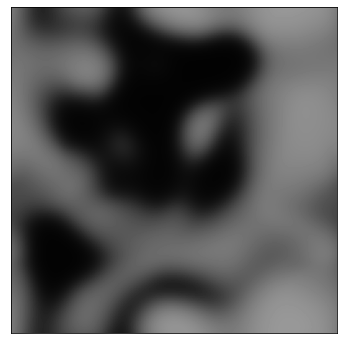

In [326]:
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['v'])
n_tips=dict_out['n']
print(f"{n_tips} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
plt.show(fig)

In [139]:
#save texture at this time t
save=False
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=f"{nb_dir}/Data/test_data/test_txt_LR_euler_t_{int(t)}.npz"
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,[txt])

In [201]:
np.max(img)

12.098689343212394

In [94]:
dt, arr39, one_step_method = get_one_step_explicit_synchronous_splitting(nb_dir,dt)

txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt = unstack_txt(txt)
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
one_step_method(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# txt_nxt=
# stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [105]:
#forward euler explicit synchronous integration
tf=1000.
tmax=tf
save_every_n_frames=10.
V_threshold=25.#mV0.#-37.#mV
level1=V_threshold; level2=0.
num_steps=int(tf/dt)
step_count=0
n_tips_lst=[];t_lst=[];dict_out_lst=[]
save_dict_every=100
n_tips=1
while (t<tmax) & (n_tips > 0):
    if step_count%save_every_n_frames != 0:
        #forward Euler integration in time
        txt=one_step_map(txt)
    else:   

        #compute tip locations in dict_out
        #update texture namespace
        inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
        txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        img=inVc[...,0]
        dimgdt=dVcdt[...,0]
        dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)

        #save tip data
        n_tips=dict_out['n']
        n_tips_lst.append(n_tips)
        t_lst.append(t)
        #         if count%save_dict_every==0:
        dict_out_lst.append(dict_out)
    
        #integrate by dt
        txt=one_step_map(txt)
    t+=dt
    step_count+=1
    printProgressBar(step_count,num_steps)
    if n_tips==0:
        print(f"zero tips remaining at time t={t}!")
        break
beep(3)

zero tips remaining at time t=100.53000000000027!


0

In [ ]:
n_tips

In [ ]:
img=inVc[...,0]
dimgdt=dVcdt[...,0]

x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['v'])
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
plt.show(fig)
print(f"{dict_out['n']} tips are present at time {int(t)}.")

In [ ]:
#save texture at this time t
save=True
if save:
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=f"{nb_dir}/Data/test_data/test_txt_LR_euler_t_{int(t)}.npz"
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,[txt])

#for asynchronous integration
#def ...kernel(txt)
#read element variables
#interpolate parameters from lookup_table
#half step voltage and calcium
#full step gating variables
# comp_exact_next_gating_var(inCgate,outCgate,arr_interp)
#half step voltage and calcium
# Iion, dCa_i_dt=comp_ionic_flux(inCgate,arr_interp)
#compute next time step
#push element to priority queue 

In [11]:
# #initialize simulation
# t=100
# num_steps=int(tf/dt)
# input_file_name=f"{nb_dir}/Data/test_data/test_txt_LR_euler_t_100.npz"
# txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 45., Vmin = -75.)
# inVc=txt[...,(0,-1)].copy()
# inmhjdfx=txt[...,1:-1].copy()
# outVc=inVc.copy()
# dVcdt=inVc.copy()
# outmhjdfx=inmhjdfx.copy()


In [ ]:
#TODO: test the explicit_synchronous_splitting_one_step_kernel as is for stability
# one_step_explicit_synchronous_splitting(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,dt,arr39)
# t+=dt
#TODO?: if ^that's unstable at dt=0.1, try again making use of the IMR
#TODO: if ^that's still unstable, consider asynchronous integration.  this would require splitting 3 task types, hence 3 priority queues
dimg=(img_out_new-img_out)[...,0]

plt.hist(dimg.flatten())
plt.xlabel('change in voltage (mV)')
plt.show()

# is the simulation already stable at dt=0.1 for t>100? yes.

# TODO: check that the simulation is moving at a reasonable time scale

# TODO: dev dormand-prince method

In [ ]:
# def get_comp_flow_map(nb_dir,dt):
#     dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,dt)
#     @njit
#     def comp_flow_map(txt):
#         #unstack txt
#         inVc,outVc,inmhjdfx,outmhjdfx,dVcdt = unstack_txt(txt)
#         #integrate by dt
#         one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# #         t+=dt
#         #stack txt
#         txt_nxt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#         return txt_nxt
#     return comp_flow_map
# @njit
# def unstack_txt(txt):
#     inVc=txt[...,0:2]
#     outVc=txt[...,2:4]
#     inmhjdfx=txt[...,4:10]
#     outmhjdfx=txt[...,10:14]
#     dVcdt=txt[...,14:16]
#     return inVc,outVc,inmhjdfx,outmhjdfx,dVcdt
# @njit
# def stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt):
#     txt=np.stack((
#         inVc[...,0],
#         inVc[...,1],
#         outVc[...,0],
#         outVc[...,1],
#         inmhjdfx[...,0],
#         inmhjdfx[...,1],
#         inmhjdfx[...,2],
#         inmhjdfx[...,3],
#         inmhjdfx[...,4],
#         inmhjdfx[...,5],
#         outmhjdfx[...,0],
#         outmhjdfx[...,1],
#         outmhjdfx[...,2],
#         outmhjdfx[...,3],
#         outmhjdfx[...,4],
#         outmhjdfx[...,5],
#         dVcdt[...,0],
#         dVcdt[...,1]
#     )).T
#     return txt

In [ ]:
#for each dti=dt*ci for ci listed in the dormand-prince method
C = np.array([0, 1/5, 3/10, 4/5, 8/9, 1])

dt=0.01
#get one_step method
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(nb_dir,dt=dt)
one_step0 = lambda x:x
dt2, _, one_step1 = get_one_step_explicit_synchronous_splitting(nb_dir,dt=C[1]*dt)
dt3, _, one_step2 = get_one_step_explicit_synchronous_splitting(nb_dir,dt=C[2]*dt)
dt4, _, one_step3 = get_one_step_explicit_synchronous_splitting(nb_dir,dt=C[3]*dt)
dt5, _, one_step4 = get_one_step_explicit_synchronous_splitting(nb_dir,dt=C[4]*dt)
dt6, _, one_step5 = get_one_step_explicit_synchronous_splitting(nb_dir,dt=C[5]*dt)

In [ ]:
comp_flow_map=get_comp_flow_map(nb_dir,dt)

In [ ]:



txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
txt_nxt=comp_flow_map(txt)
t+=dt

In [ ]:
txt=txt_nxt.copy()
txt_nxt=comp_flow_map(txt)
t+=dt


In [ ]:
np.max(txt-txt_nxt)

In [ ]:
1

In [ ]:
1

# TODO: plot Iion versus V for several dVdt fixed, sampling from the texture after time stepping for 100ms stabily
- TODO: compute dVdt_ion = I_ion/C_m = bilinear_interpolation( V, dVdt, lookup_table)

# adaptive time stepping appears to not be necessary for stability.  making spiral waves is the real limiting reagent... 